In [1]:
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd
import math
from tqdm.notebook import tqdm
import time
import pyautogui
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
img = cv2.imread('./flp/traintry001/r99999.jpg')

In [35]:
def RotateImage(img, angle, scale=1):
    if img.ndim > 2:
        height, width, channel = img.shape
    else:
        height, width = img.shape
 
    matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, scale)
    result = cv2.warpAffine(img, matrix, (width, height))
 
    return result
 
img = cv2.imread('./flp/traintry001/r99999.jpg')
 
rad = 20 * math.pi / 180	# 각도 설정
res = RotateImage(img, -30, 1)
res2 = RotateImage(img, 30, 1)
cv2.imshow('original', img)
cv2.imshow('result', res)
cv2.imshow('result2', res2)
cv2.waitKey()
cv2.destroyAllWindows()

In [7]:
import glob
import os
path = './flp/traindata_forrotation/'
file_list = os.listdir(path)
jpg_file_list = [file for file in file_list if file.endswith(".jpg")]
print("len(jpg_file_list):",len(jpg_file_list))
print(jpg_file_list[:3])

len(jpg_file_list): 3041
['1.jpg', '10.jpg', '101.jpg']


In [ ]:
photo_data = []
IMAGE_FILES = jpg_file_list
# IMAGE_FILES = ['r99999.jpg']
#사진상 사람의 코 위치 검출
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

with mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    refine_face_landmarks=True) as holistic:
    idx=0
    for file in tqdm(IMAGE_FILES):
        img = cv2.imread('./flp/traintry001/'+file)
        
        for angle in range(0, 181, 30):
            for size in range(4, 11,3):
                rad = 20 * math.pi / 180	# 각도 설정
                image = RotateImage(img, angle-90, size/10)
                results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                 
########################################################################################################
#prepare data#                
                if results.pose_landmarks:
                    n=[]
                    for data_point in results.pose_landmarks.landmark:
                        n.append(data_point.x)
                        n.append(data_point.y)
                        n.append(data_point.z)
                    n.append(angle)

                    photo_data.append(n)

                else:
                    continue


  0%|          | 0/3041 [00:00<?, ?it/s]

In [10]:
import csv
f = open('./flp/photo_data_rotate002.csv', 'w', newline='')
writer = csv.writer(f)
writer.writerows(photo_data)
f.close()

In [11]:
photo_data = pd.read_csv('./flp/photo_data_rotate001.csv', header=None).to_numpy()
photo_data.shape

(3143, 100)

In [12]:
photo_data[1][0]

0.5022152662277222

In [13]:
print("전체데이터 개수 :",len(photo_data))
photo_data = photo_data.tolist()

전체데이터 개수 : 3143


In [14]:
x = []
y = []
for i in tqdm(photo_data):
    x.append(i[:99])
    y.append([i[99]])

  0%|          | 0/3143 [00:00<?, ?it/s]

In [15]:
y[:1]

[[0.0]]

In [17]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(x, y, 
                                                      test_size=0.2, 
                                                      shuffle=True,  
                                                      random_state=42)

In [18]:
import numpy as np

# 데이터셋 생성
train_data = np.array(train_data)
train_targets = np.array(train_targets)
test_data = np.array(test_data)
test_targets = np.array(test_targets)

print("traindata shape:",train_data.shape)
print("traintarget shape:",train_targets.shape)

traindata shape: (2514, 99)
traintarget shape: (2514, 1)


In [19]:
from keras import models
from keras import layers

def build_model(): 
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [20]:
k = 2

num_val_samples = len(train_data) // k
num_epochs = 10
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  # 검증 데이터 준비: k번째 분할
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()  # 케라스 모델 구성(컴파일 포함)
    model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
              epochs=num_epochs, batch_size=1, verbose=1)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  # 검증 세트로 모델 평가
    all_scores.append(val_mae)

처리중인 폴드 # 0
Epoch 1/10
1257/1257 [==============================] - 2s 970us/step - loss: 777.7140 - mae: 21.4596
Epoch 2/10
1257/1257 [==============================] - 1s 994us/step - loss: 243.3495 - mae: 11.2944
Epoch 3/10
1257/1257 [==============================] - 1s 960us/step - loss: 195.1047 - mae: 9.3862
Epoch 4/10
1257/1257 [==============================] - 1s 1ms/step - loss: 176.6986 - mae: 8.4773
Epoch 5/10
1257/1257 [==============================] - 1s 1ms/step - loss: 171.0934 - mae: 7.7849
Epoch 6/10
1257/1257 [==============================] - 2s 1ms/step - loss: 159.5146 - mae: 7.5500
Epoch 7/10
1257/1257 [==============================] - 2s 1ms/step - loss: 154.3760 - mae: 7.1714
Epoch 8/10
1257/1257 [==============================] - 1s 1ms/step - loss: 146.7647 - mae: 6.8192
Epoch 9/10
1257/1257 [==============================] - 2s 1ms/step - loss: 144.4366 - mae: 6.6297
Epoch 10/10
1257/1257 [==============================] - 1s 1ms/step - loss: 139.0306 - m

In [21]:
num_epochs = 30
all_mae_histories = []
for i in tqdm(range(k)):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  #검증 데이터 준비: k번째 분할    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()  # 케라스 모델 구성(컴파일 포함)
    history = model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

  0%|          | 0/2 [00:00<?, ?it/s]

처리중인 폴드 # 0
처리중인 폴드 # 1


In [22]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

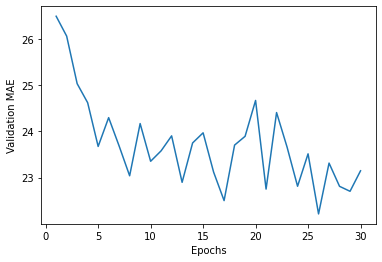

In [32]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [23]:
model = build_model()  # 새롭게 컴파일된 모델을 얻습니다.
model.fit(train_data, train_targets,  # 전체 데이터로 훈련시킵니다.
          epochs=15, batch_size=64, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

20/20 [==============================] - 0s 1ms/step - loss: 158.3548 - mae: 8.0833


In [24]:
test_mse_score
test_mae_score

8.083285331726074

In [25]:
print(model.predict([photo_data[0][:99]]))

print(photo_data[0][99])

1/1 [==============================] - 0s 83ms/step
[[6.745231]]
0.0


In [28]:
def get_angle(data):
    p = model.predict(data)[0][0]
    return p

In [29]:
print("현재 영상의 기울어짐")
get_angle([photo_data[0][:99]])

현재 영상의 기울어짐
1/1 [==============================] - 0s 28ms/step


6.745231

In [31]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

cap = cv2.VideoCapture('./flp/traindata_forrotation/rotate001.mp4')

with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        idx+=1
#         time.sleep(0.001)
#         pyautogui.PAUSE = 1    # 딜레이 관련 (default = 0.1 초)
        pyautogui.FAILSAFE = False  # 강제 초기화 비활성
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
    # If loading a video, use 'break' instead of 'continue'.
            break

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = holistic.process(image)
        
        n=[]
        visibility =[]
        if results.pose_landmarks:
            for data_point in results.pose_landmarks.landmark:
                n.append(data_point.x)
                n.append(data_point.y)
                n.append(data_point.z)
                visibility.append(data_point.visibility)
        else:
            for _ in range(99):
                n.append(0)

        life_probability = get_angle(nowdata)
        text="angle : {}".format(round(life_probability,2))
        org=(30,30)
        font=cv2.FONT_HERSHEY_SIMPLEX
 
    # Draw landmark annotation on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        save_image = image.copy()
#         mp_drawing.draw_landmarks(
#             image,
#             results.face_landmarks,
#             mp_holistic.FACEMESH_CONTOURS,
#             landmark_drawing_spec=None,
#             connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
        cv2.putText(image,text,org,font,1,(255,0,0),2)
    # Flip the image horizontally for a selfie-view display.
        cv2.imshow('MediaPipe Holistic', image)
        if cv2.waitKey(1) & 0xFF == 27:
            break

cv2.destroyAllWindows()
cap.release()

변한 거리 : 19.34352310508621
1/1 [==============================] - 0s 26ms/step
변한 거리 : 0.026985855400752507
1/1 [==============================] - 0s 29ms/step
변한 거리 : 0.003945966833258659
1/1 [==============================] - 0s 29ms/step
변한 거리 : 0.000257048358124821
1/1 [==============================] - 0s 27ms/step
변한 거리 : 0.005275445425913455
1/1 [==============================] - 0s 27ms/step
변한 거리 : 0.001331673132758354
1/1 [==============================] - 0s 26ms/step
변한 거리 : 0.0018054172173522101
1/1 [==============================] - 0s 26ms/step
변한 거리 : 0.0004421890180805766
1/1 [==============================] - 0s 28ms/step
변한 거리 : 0.002543072652690131
1/1 [==============================] - 0s 27ms/step
변한 거리 : 7.78431769347748e-05
1/1 [==============================] - 0s 28ms/step
변한 거리 : 0.003710763275459392
1/1 [==============================] - 0s 27ms/step
변한 거리 : 0.000247875229170665
1/1 [==============================] - 0s 27ms/step
변한 거리 : 0.001001731720720695


1/1 [==============================] - 0s 27ms/step
변한 거리 : 0.0010694343004060778
1/1 [==============================] - 0s 27ms/step
변한 거리 : 0.0012103854378000896
1/1 [==============================] - 0s 28ms/step
변한 거리 : 0.007867191277794242
1/1 [==============================] - 0s 27ms/step
변한 거리 : 0.01368650378208077
1/1 [==============================] - 0s 38ms/step
변한 거리 : 0.0014016524745844488
1/1 [==============================] - 0s 28ms/step
변한 거리 : 0.019659869784110762
1/1 [==============================] - 0s 25ms/step
변한 거리 : 0.006656583346776255
1/1 [==============================] - 0s 37ms/step
변한 거리 : 0.010596132229790908
1/1 [==============================] - 0s 29ms/step
변한 거리 : 0.0037462069540878393
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.019058485608388753
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.007324983903128838
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.0032239089676739533
1/1 [===================

1/1 [==============================] - 0s 57ms/step
변한 거리 : 0.0004999615185967675
1/1 [==============================] - 0s 57ms/step
변한 거리 : 0.00044427160464324063
1/1 [==============================] - 0s 39ms/step
변한 거리 : 0.00038619179984913894
1/1 [==============================] - 0s 39ms/step
변한 거리 : 0.0005147499002411591
1/1 [==============================] - 0s 36ms/step
변한 거리 : 0.001356539314027661
1/1 [==============================] - 0s 37ms/step
변한 거리 : 0.0008247883237155684
1/1 [==============================] - 0s 35ms/step
변한 거리 : 0.0020732726870643014
1/1 [==============================] - 0s 35ms/step
변한 거리 : 0.0004936632810652202
1/1 [==============================] - 0s 35ms/step
변한 거리 : 0.0028083825507983296
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.0012120585313242908
1/1 [==============================] - 0s 34ms/step
변한 거리 : 0.0008736630527156823
1/1 [==============================] - 0s 34ms/step
변한 거리 : 0.0008435859838205962
1/1 [==========

1/1 [==============================] - 0s 30ms/step
변한 거리 : 0.022942972329994666
1/1 [==============================] - 0s 30ms/step
변한 거리 : 0.00047665283770193895
1/1 [==============================] - 0s 30ms/step
변한 거리 : 0.07047046136417005
1/1 [==============================] - 0s 31ms/step
변한 거리 : 0.0544598090889291
1/1 [==============================] - 0s 31ms/step
변한 거리 : 0.0026372679621626365
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.17278412816758715
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.3998680267948158
1/1 [==============================] - 0s 36ms/step
변한 거리 : 0.04812632418900377
1/1 [==============================] - 0s 34ms/step
변한 거리 : 0.11882638154681155
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.003435592252817123
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.007979891396259951
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.00024258315703704764
1/1 [==========================

1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.0013245606655392294
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.0027609329039396243
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.0028127404415215075
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.001127910901209831
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.002467738775747395
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.002194276659098872
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.002576177568575134
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.004135496542521681
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.0010314421207815424
1/1 [==============================] - 0s 30ms/step
변한 거리 : 0.0031309251065607478
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.002269199971705564
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.001694510257851173
1/1 [==================

1/1 [==============================] - 0s 34ms/step
변한 거리 : 0.7408201582226657
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.03814784121923449
1/1 [==============================] - 0s 35ms/step
변한 거리 : 0.003914133425409493
1/1 [==============================] - 0s 35ms/step
변한 거리 : 0.6193169363908181
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.585008708793932
1/1 [==============================] - 0s 34ms/step
변한 거리 : 0.034240400215361316
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.0034044936740251874
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.018590975337895683
1/1 [==============================] - 0s 40ms/step
변한 거리 : 0.006905626965365359
1/1 [==============================] - 0s 38ms/step
변한 거리 : 0.005588037309493316
1/1 [==============================] - 0s 39ms/step
변한 거리 : 0.002234752075913507
1/1 [==============================] - 0s 39ms/step
변한 거리 : 0.005273218148249333
1/1 [==============================

1/1 [==============================] - 0s 37ms/step
변한 거리 : 0.0019414097791805494
1/1 [==============================] - 0s 38ms/step
변한 거리 : 0.0008439551848666356
1/1 [==============================] - 0s 37ms/step
변한 거리 : 0.011835925102428922
1/1 [==============================] - 0s 37ms/step
변한 거리 : 0.0016840939189827879
1/1 [==============================] - 0s 34ms/step
변한 거리 : 0.0013502506230737257
1/1 [==============================] - 0s 34ms/step
변한 거리 : 0.0008905729480047609
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.0007532670106891677
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.004408513481036565
1/1 [==============================] - 0s 34ms/step
변한 거리 : 0.006553416785791766
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.008960787138783071
1/1 [==============================] - 0s 32ms/step
변한 거리 : 0.0011435703077535525
1/1 [==============================] - 0s 33ms/step
변한 거리 : 0.0022251226621040417
1/1 [===============